#### Explore [CORINE Land Cover](https://land.copernicus.eu/en/map-viewer?dataset=0407d497d3c44bcd93ce8fd5bf78596a) data 2018 for Ireland - data collected drawing a bounding box around Ireland and Northern Ireland

1. Explore CORINE landuse data
2. Explore landuse/landcoverage around solar and wind infrastructures (data from `IE_power.ipynb`)

Dependencies:

In [1]:
import geopandas as gpd
import pandas as pd
import fiona
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from shapely import wkt
from shapely.geometry import MultiPoint
import folium
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import seaborn as sns
from collections import Counter
from shapely.ops import unary_union
from matplotlib.colors import ListedColormap
from matplotlib.patches import Circle
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
# utils functions 
from utils import get_landuse_share, find_landuses_within_buffer, find_area_covered_by_landuse_within_buffer
# utils plots
from utils import parse_color, map_by_label, freq_landuse_types, bubble_map

Data paths:

In [2]:
# path to CORINE geodatabase (.gdb)
gdb_path = '../data/EU_data/CORINE_LandCover_2018/Results/U2018_CLC2018_V2020_20u1.gdb'
# path codes legend
path_legend = '../data/EU_data/CORINE_LandCover_2018/Results/U2018_CLC2018_V2020_20u1_doc/Info/Legend/Vector/clc_legend.xls'

# OSM data (preprocessed)
wind_data_path = 'output_data/IE/IE_wind_df.csv' # OSM wind turbines data
solar_data_path = 'output_data/IE/IE_solar_df.csv' # OSM solar farms data

# EPSG for conversions
epsg_meter = 3035 # EPSG:3035
epsg_latlon = 4326 # EPSG:4326

______

In [3]:
# get layer names
layers = fiona.listlayers(gdb_path)

# put each layer into geodataframe
for layer_name in layers:
    layer_gdf = gpd.read_file(gdb_path, driver='OpenFileGDB', layer=layer_name)
    # print(layer_gdf.head())  


/home/luisa/Documents/OSM_StateOfTheMap_Conference_Nairobi2024/OSMRenewables/.venv/lib/python3.10/site-packages/pyogrio/raw.py:196: RuntimeWarning: driver OpenFileGDB does not support open option DRIVER
  return ogr_read(
/home/luisa/Documents/OSM_StateOfTheMap_Conference_Nairobi2024/OSMRenewables/.venv/lib/python3.10/site-packages/pyogrio/raw.py:196: RuntimeWarning: organizePolygons() received a polygon with more than 100 parts. The processing may be really slow.  You can skip the processing by setting METHOD=SKIP, or only make it analyze counter-clock wise parts by setting METHOD=ONLY_CCW if you can assume that the outline of holes is counter-clock wise defined
  return ogr_read(


In [4]:
layer_gdf

Code_18 Remark       Area_Ha          ID  Shape_Length  Shape_Area  \
0         111   None     27.682220  EU_1549037      0.034836    0.000036   
1         111   None    178.575415  EU_1549038      0.107748    0.000233   
2         111   None    125.327155  EU_1549039      0.076922    0.000165   
3         111   None    108.618247  EU_1549040      0.063353    0.000143   
4         111   None     48.483721  EU_1549041      0.042783    0.000064   
...       ...    ...           ...         ...           ...         ...   
22100     423   None    773.880933  EU_2372094      0.301574    0.001062   
22101     512   None     35.585549  EU_2372095      0.033539    0.000049   
22102     512   None    174.321228  EU_2372096      0.058924    0.000242   
22103     512   None  38205.301313  EU_2372097      1.668372    0.053123   
22104     412   None  30115.885562  EU_2372312      0.494755    0.002533   

                                                geometry  
0      MULTIPOLYGON (((-7.84152 51.94764, -7.84197 51...  
1      MULTIPOLYGON (((-8.47123 51.91222, -8.47179 51...  
2      MULTIPOLYGON (((-6.45955 52.33984, -6.45925 52...  
3      MULTIPOLYGON (((-7.10001 52.25684, -7.10026 52...  
4      MULTIPOLYGON (((-6.94932 52.39008, -6.94999 52...  
...                                                  ...  
22100  MULTIPOLYGON (((-6.15428 54.06564, -6.15492 54...  
22101  MULTIPOLYGON (((-6.18696 54.3352, -6.18709 54....  
22102  MULTIPOLYGON (((-6.27406 54.5522, -6.27714 54....  
22103  MULTIPOLYGON (((-6.47583 54.75068, -6.47364 54...  
22104  MULTIPOLYGON (((-5.9497 55.82325, -5.94882 55....  

[22105 rows x 7 columns]

<Axes: >

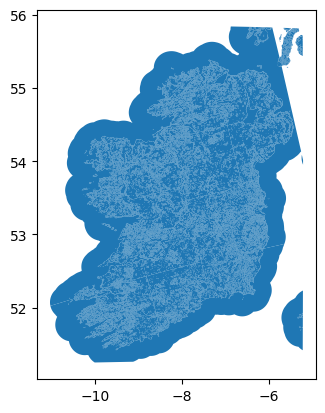

In [5]:
layer_gdf.plot()

/tmp/ipykernel_13076/2922931885.py:12: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  uk['centroid_lon'] = uk.geometry.centroid.x
/tmp/ipykernel_13076/2922931885.py:13: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  uk['centroid_lat'] = uk.geometry.centroid.y


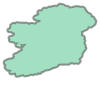

In [6]:
# GET PHYSICAL BORDERS DATA FROM [NATURAL EARTH], TO FILTER ONLY IRELAND AND NORTHERN IRELAND
countries_pysical_borders = gpd.read_file('../data/ne_10m_admin_0_countries.zip')

# Ireland geometry
ie = countries_pysical_borders[countries_pysical_borders.ADMIN=='Ireland'].geometry.item()

# UK geometry:
# separate the polygons that compose UK with explode, 
# then get the polygon centroids (just to get average lat and lon - ignore warnings for metric)
# and filter centroid range of Northern Ireland
uk = countries_pysical_borders[countries_pysical_borders.ADMIN=='United Kingdom'].explode(index_parts=False).reset_index(drop=True)
uk['centroid_lon'] = uk.geometry.centroid.x
uk['centroid_lat'] = uk.geometry.centroid.y

ni = uk[((uk['centroid_lon'] > -10) & (uk['centroid_lon'] < -5))&((uk['centroid_lat'] > 54)&(uk['centroid_lat'] < 55))].geometry.item()

# union IE and NI
all_ie = ie.union(ni)
all_ie = all_ie.buffer(0.1)  # add small buffer to capture small islands around IE
all_ie

In [7]:
# mask to keep only IE and NI (discarding other pieces of UK)
mask_ie_island = layer_gdf.geometry.intersects(all_ie)
gdf_ie_ni = layer_gdf[mask_ie_island].reset_index(drop=True)

<Axes: >

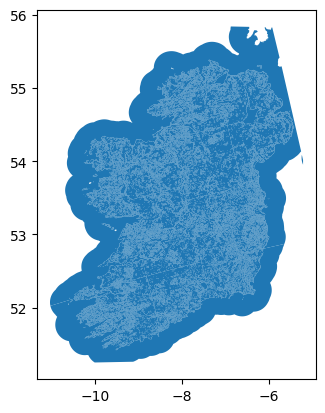

In [8]:
gdf_ie_ni.plot() # filtered out part of uk previously appearing

In [9]:
#!pip install xlrd==2.0.1

In [10]:
legend_df = pd.read_excel(path_legend)
legend_df

GRID_CODE  CLC_CODE                         LABEL1  \
0           1       111            Artificial surfaces   
1           2       112            Artificial surfaces   
2           3       121            Artificial surfaces   
3           4       122            Artificial surfaces   
4           5       123            Artificial surfaces   
5           6       124            Artificial surfaces   
6           7       131            Artificial surfaces   
7           8       132            Artificial surfaces   
8           9       133            Artificial surfaces   
9          10       141            Artificial surfaces   
10         11       142            Artificial surfaces   
11         12       211             Agricultural areas   
12         13       212             Agricultural areas   
13         14       213             Agricultural areas   
14         15       221             Agricultural areas   
15         16       222             Agricultural areas   
16         17       223             Agricultural areas   
17         18       231             Agricultural areas   
18         19       241             Agricultural areas   
19         20       242             Agricultural areas   
20         21       243             Agricultural areas   
21         22       244             Agricultural areas   
22         23       311  Forest and semi natural areas   
23         24       312  Forest and semi natural areas   
24         25       313  Forest and semi natural areas   
25         26       321  Forest and semi natural areas   
26         27       322  Forest and semi natural areas   
27         28       323  Forest and semi natural areas   
28         29       324  Forest and semi natural areas   
29         30       331  Forest and semi natural areas   
30         31       332  Forest and semi natural areas   
31         32       333  Forest and semi natural areas   
32         33       334  Forest and semi natural areas   
33         34       335  Forest and semi natural areas   
34         35       411                       Wetlands   
35         36       412                       Wetlands   
36         37       421                       Wetlands   
37         38       422                       Wetlands   
38         39       423                       Wetlands   
39         40       511                   Water bodies   
40         41       512                   Water bodies   
41         42       521                   Water bodies   
42         43       522                   Water bodies   
43         44       523                   Water bodies   
44         48       999                         NODATA   
45         49       990                   UNCLASSIFIED   
46         50       995                   UNCLASSIFIED   
47        255       990                   UNCLASSIFIED   

                                             LABEL2  \
0                                      Urban fabric   
1                                      Urban fabric   
2        Industrial, commercial and transport units   
3        Industrial, commercial and transport units   
4        Industrial, commercial and transport units   
5        Industrial, commercial and transport units   
6                 Mine, dump and construction sites   
7                 Mine, dump and construction sites   
8                 Mine, dump and construction sites   
9      Artificial, non-agricultural vegetated areas   
10     Artificial, non-agricultural vegetated areas   
11                                      Arable land   
12                                      Arable land   
13                                      Arable land   
14                                  Permanent crops   
15                                  Permanent crops   
16                                  Permanent crops   
17                                         Pastures   
18                 Heterogeneous agricultural areas   
19                 Heterogeneous agricultural areas   
20    

In [11]:
layer_gdf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 22105 entries, 0 to 22104
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   Code_18       22105 non-null  object  
 1   Remark        0 non-null      object  
 2   Area_Ha       22105 non-null  float64 
 3   ID            22105 non-null  object  
 4   Shape_Length  22105 non-null  float64 
 5   Shape_Area    22105 non-null  float64 
 6   geometry      22105 non-null  geometry
dtypes: float64(3), geometry(1), object(3)
memory usage: 1.2+ MB


In [12]:
gdf_ie_ni['Code_18'] = gdf_ie_ni['Code_18'].astype('int')
legend_df['GRID_CODE'] = legend_df['GRID_CODE'].astype('int')

In [13]:
# merge gdf with legend
gdf = gdf_ie_ni.merge(legend_df, left_on='Code_18', right_on='CLC_CODE', how='left')

In [14]:
gdf.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [15]:
gdf

Code_18 Remark       Area_Ha          ID  Shape_Length  Shape_Area  \
0          111   None     27.682220  EU_1549037      0.034836    0.000036   
1          111   None    178.575415  EU_1549038      0.107748    0.000233   
2          111   None    125.327155  EU_1549039      0.076922    0.000165   
3          111   None    108.618247  EU_1549040      0.063353    0.000143   
4          111   None     48.483721  EU_1549041      0.042783    0.000064   
...        ...    ...           ...         ...           ...         ...   
21568      423   None    261.094403  EU_2372093      0.344154    0.000358   
21569      423   None    773.880933  EU_2372094      0.301574    0.001062   
21570      512   None     35.585549  EU_2372095      0.033539    0.000049   
21571      512   None    174.321228  EU_2372096      0.058924    0.000242   
21572      512   None  38205.301313  EU_2372097      1.668372    0.053123   

                                                geometry  GRID_CODE  CLC_CODE  \
0      MULTIPOLYGON (((-7.84152 51.94764, -7.84197 51...          1       111   
1      MULTIPOLYGON (((-8.47123 51.91222, -8.47179 51...          1       111   
2      MULTIPOLYGON (((-6.45955 52.33984, -6.45925 52...          1       111   
3      MULTIPOLYGON (((-7.10001 52.25684, -7.10026 52...          1       111   
4      MULTIPOLYGON (((-6.94932 52.39008, -6.94999 52...          1       111   
...                                                  ...        ...       ...   
21568  MULTIPOLYGON (((-5.95995 54.06495, -5.96097 54...         39       423   
21569  MULTIPOLYGON (((-6.15428 54.06564, -6.15492 54...         39       423   
21570  MULTIPOLYGON (((-6.18696 54.3352, -6.18709 54....         41       512   
21571  MULTIPOLYGON (((-6.27406 54.5522, -6.27714 54....         41       512   
21572  MULTIPOLYGON (((-6.47583 54.75068, -6.47364 54...         41       512   

                    LABEL1             LABEL2                   LABEL3  \
0      Artificial surfaces       Urban fabric  Continuous urban fabric   
1      Artificial surfaces       Urban fabric  Continuous urban fabric   
2      Artificial surfaces       Urban fabric  Continuous urban fabric   
3      Artificial surfaces       Urban fabric  Continuous urban fabric   
4      Artificial surfaces       Urban fabric  Continuous urban fabric   
...                    ...                ...                      ...   
21568             Wetlands  Maritime wetlands         Intertidal flats   
21569             Wetlands  Maritime wetlands         Intertidal flats   
21570         Water bodies      Inland waters             Water bodies   
21571         Water bodies      Inland waters             Water bodies   
21572         Water bodies      Inland waters             Water bodies   

               RGB  
0      230-000-077  
1      230-000-077  
2      230-000-077  
3      230-000-077  
4      230-000-077  
...            ...  
21568  166-166-230  
21569  166-166-230  
21570  128-242-230  
21571  128-242-230  
21572  128-242-230  

[21573 rows x 13 columns]

In [16]:
gdf[(gdf.LABEL1=='UNCLASSIFIED') | (gdf.LABEL1 == 'NODATA')]

Empty GeoDataFrame
Columns: [Code_18, Remark, Area_Ha, ID, Shape_Length, Shape_Area, geometry, GRID_CODE, CLC_CODE, LABEL1, LABEL2, LABEL3, RGB]
Index: []

In [17]:
gdf.LABEL3.nunique()

35

In [18]:
gdf[['RGB', 'LABEL3']]

RGB                   LABEL3
0      230-000-077  Continuous urban fabric
1      230-000-077  Continuous urban fabric
2      230-000-077  Continuous urban fabric
3      230-000-077  Continuous urban fabric
4      230-000-077  Continuous urban fabric
...            ...                      ...
21568  166-166-230         Intertidal flats
21569  166-166-230         Intertidal flats
21570  128-242-230             Water bodies
21571  128-242-230             Water bodies
21572  128-242-230             Water bodies

[21573 rows x 2 columns]

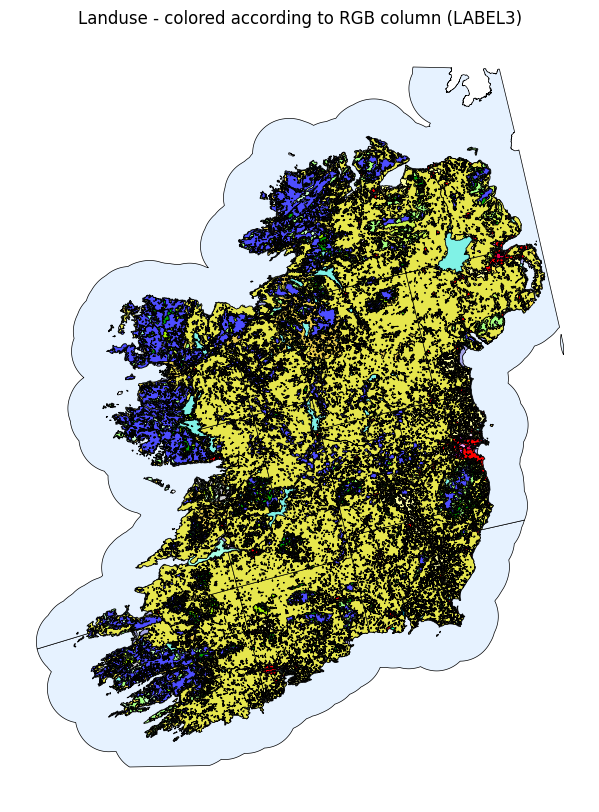

In [19]:
# convert the RGB column to RGB tuples
colors = gdf['RGB'].apply(parse_color)

# plot landuse on map according to CORINE color-scheme
fig, ax = plt.subplots(figsize=(10, 10))
gdf.plot(ax=ax, facecolor='none', edgecolor='black', lw=0.5, color=colors, legend=True)
plt.title('Landuse - colored according to RGB column (LABEL3)')
plt.axis('off')
plt.show()


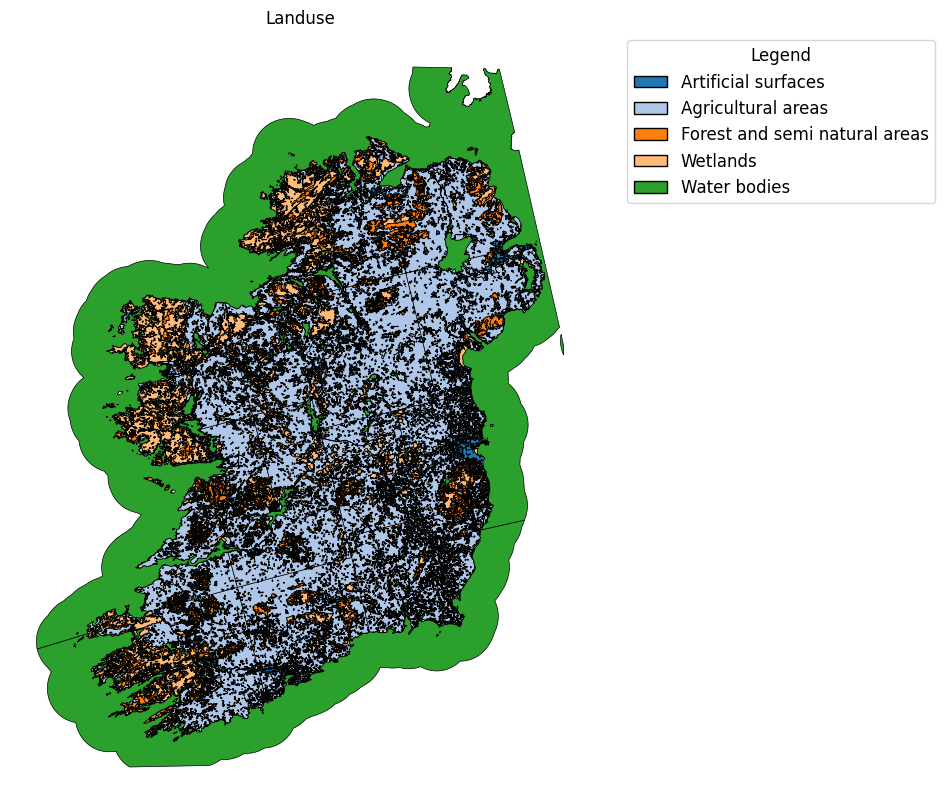

In [20]:
# plot landuse on map according to LABEL1 (more generic)
map_by_label(gdf, lab='LABEL1')

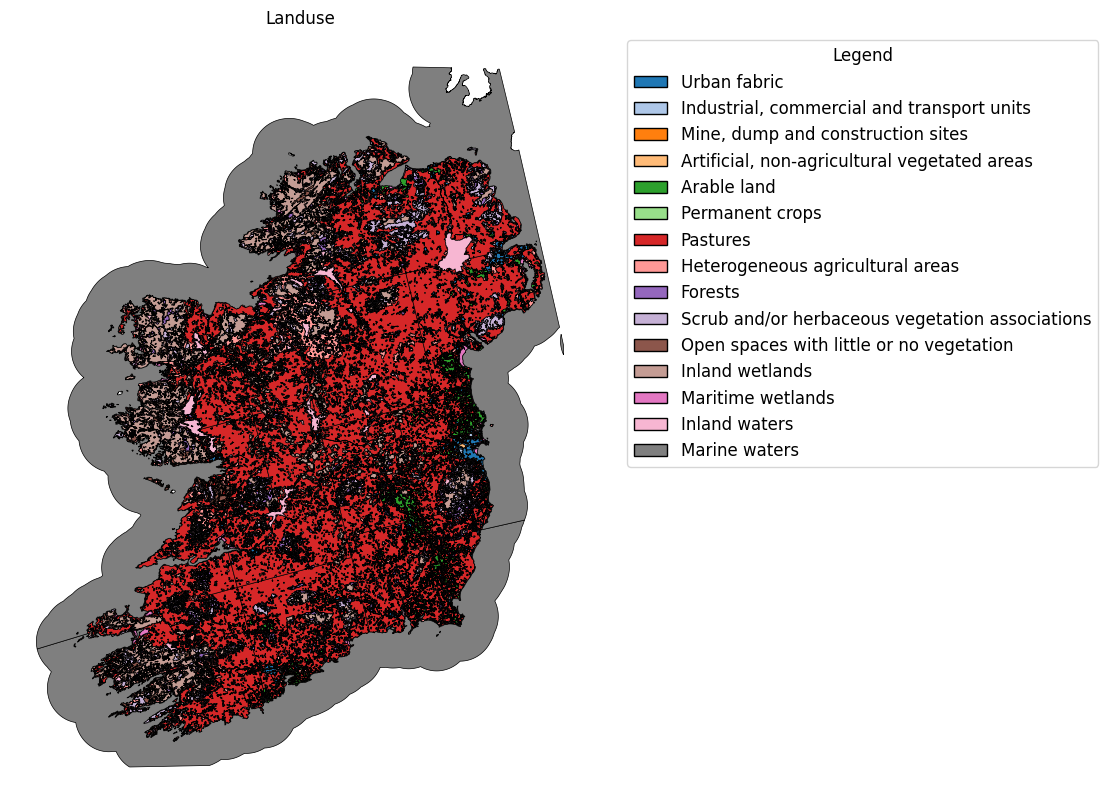

In [21]:
# plot landuse on map according to LABEL2 (intermediate specifications)
map_by_label(gdf, 'LABEL2')

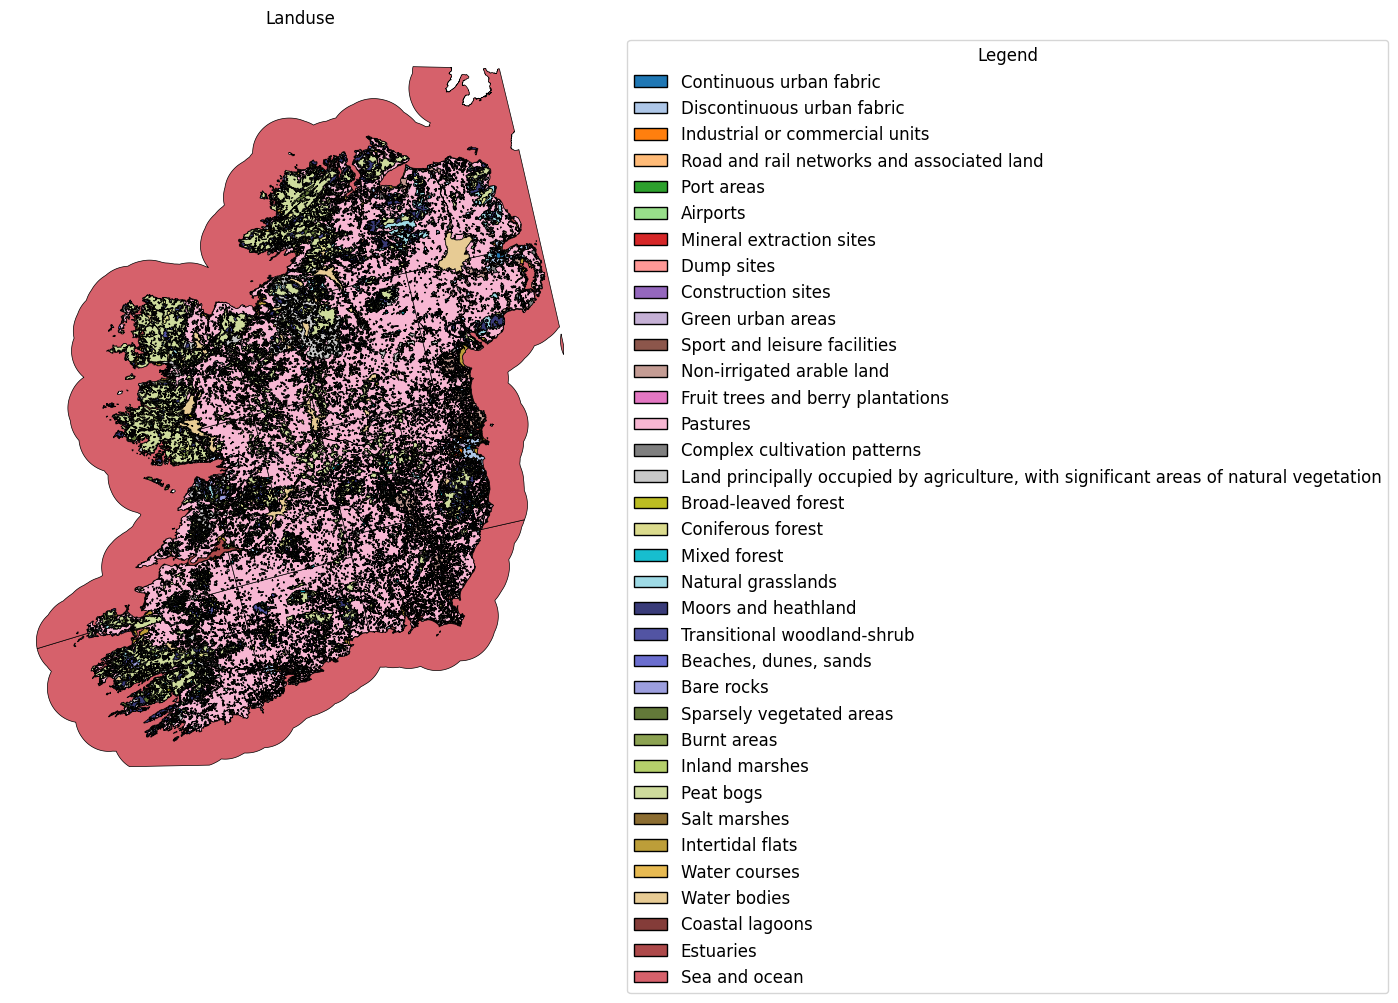

In [22]:
# plot landuse on map according to LABEL3 (detailed)
map_by_label(gdf, 'LABEL3')

Compute percentage of total land covered by each landuse category:

In [23]:
# landuse data in metric and mercator coordinate systems
landuse_gdf = gdf.to_crs(epsg=epsg_latlon)
landuse_gdf_metric = gdf.to_crs(epsg=epsg_meter) # gdf was already in metric system

In [24]:
# extensions of each landuse in Ireland (% of total country area)
# remove sea from percentage computation
gdf_metric_no_sea = landuse_gdf_metric[landuse_gdf_metric.LABEL2 != 'Marine waters'] 

# landuse share according to LABEL1
get_landuse_share(gdf=gdf_metric_no_sea, grp_by_landuse_col='LABEL1')

LABEL1
Agricultural areas               67.826935
Forest and semi natural areas    14.069803
Wetlands                         13.149270
Artificial surfaces               2.851378
Water bodies                      2.102614
Name: geometry, dtype: float64

In [25]:
# landuse share according to LABEL2
get_landuse_share(gdf=gdf_metric_no_sea, grp_by_landuse_col='LABEL2')

LABEL2
Pastures                                           56.545667
Inland wetlands                                    12.397367
Heterogeneous agricultural areas                    7.006543
Scrub and/or herbaceous vegetation associations     6.864317
Forests                                             6.076866
Arable land                                         4.270371
Inland waters                                       2.102614
Urban fabric                                        1.847795
Open spaces with little or no vegetation            1.128621
Maritime wetlands                                   0.751903
Industrial, commercial and transport units          0.418647
Artificial, non-agricultural vegetated areas        0.401601
Mine, dump and construction sites                   0.183335
Permanent crops                                     0.004354
Name: geometry, dtype: float64

In [26]:
# landuse share according to LABEL3
get_landuse_share(gdf=gdf_metric_no_sea, grp_by_landuse_col='LABEL3')

LABEL3
Pastures                                                                                  56.545667
Peat bogs                                                                                 12.103735
Land principally occupied by agriculture, with significant areas of natural vegetation     6.048771
Coniferous forest                                                                          4.394484
Non-irrigated arable land                                                                  4.270371
Transitional woodland-shrub                                                                2.830323
Moors and heathland                                                                        2.248399
Water bodies                                                                               1.999869
Natural grasslands                                                                         1.785595
Discontinuous urban fabric                                                                 1.

In [27]:
# total surface in squared-km
gdf_metric_no_sea.geometry.area.sum() / 1000000 

84619.94110977808

____________

#### Explore landuse/landcoverage around solar and wind infrastructures

#### WIND
- landuse in the exact location of wind turbines
- landuse within a given buffer wrt the wind farms as a whole

In [28]:
wind_df = pd.read_csv(wind_data_path, index_col=0)
wind_df['geometry'] = wind_df['geometry'].apply(wkt.loads)

wind_gdf = gpd.GeoDataFrame(wind_df, crs=epsg_latlon, geometry='geometry')

In [29]:
wind_gdf

id        lat       lon  power_tag  power_method power_source  \
0       n370577265  52.273302 -7.344967  generator  wind_turbine         wind   
1       n370577267  52.272950 -7.341947  generator  wind_turbine         wind   
2       n410873377  52.658500 -6.726101  generator  wind_turbine         wind   
3       n410873379  52.660736 -6.728386  generator  wind_turbine         wind   
4       n410873382  52.656670 -6.723020  generator  wind_turbine         wind   
...            ...        ...       ...        ...           ...          ...   
2908  n11521750371  54.190911 -9.887937  generator  wind_turbine         wind   
2909  n11521750372  54.192506 -9.887223  generator  wind_turbine         wind   
2910  n11521750373  54.194113 -9.886520  generator  wind_turbine         wind   
2911  n11576327724  52.325424 -8.756990  generator  wind_turbine         wind   
2912  n11576327726  52.321115 -8.760115  generator  wind_turbine         wind   

           power_type                   geometry  relation_id relation_type  \
0     horizontal_axis   POINT (-7.34497 52.2733)   15261309.0          site   
1     horizontal_axis  POINT (-7.34195 52.27295)   15261309.0          site   
2     horizontal_axis    POINT (-6.7261 52.6585)   14995512.0          site   
3     horizontal_axis  POINT (-6.72839 52.66074)   14995512.0          site   
4     horizontal_axis  POINT (-6.72302 52.65667)   14995512.0          site   
...               ...                        ...          ...           ...   
2908              NaN  POINT (-9.88794 54.19091)          NaN           NaN   
2909              NaN  POINT (-9.88722 54.19251)          NaN           NaN   
2910              NaN  POINT (-9.88652 54.19411)          NaN           NaN   
2911  horizontal_axis  POINT (-8.75699 52.32542)          NaN           NaN   
2912  horizontal_axis  POINT (-8.76012 52.32111)          NaN           NaN   

     relation_info      area_id  cluster_id  
0        wind_farm          NaN         0.0  
1        wind_farm          NaN         0.0  
2        wind_farm          NaN         1.0  
3        wind_farm          NaN         1.0  
4        wind_farm          NaN         1.0  
...            ...          ...         ...  
2908           NaN          NaN       357.0  
2909           NaN          NaN       357.0  
2910           NaN          NaN       357.0  
2911           NaN  a2490468962       358.0  
2912           NaN  a2490468962       358.0  

[2913 rows x 13 columns]

In [30]:
# use spatial join to get landuse on turbines locations
wind_farms_with_landuse = gpd.sjoin(wind_gdf, landuse_gdf, how='left', predicate='within')
wind_farms_with_landuse.drop(columns=['index_right'], inplace=True)
wind_farms_with_landuse

id        lat       lon  power_tag  power_method power_source  \
0       n370577265  52.273302 -7.344967  generator  wind_turbine         wind   
1       n370577267  52.272950 -7.341947  generator  wind_turbine         wind   
2       n410873377  52.658500 -6.726101  generator  wind_turbine         wind   
3       n410873379  52.660736 -6.728386  generator  wind_turbine         wind   
4       n410873382  52.656670 -6.723020  generator  wind_turbine         wind   
...            ...        ...       ...        ...           ...          ...   
2908  n11521750371  54.190911 -9.887937  generator  wind_turbine         wind   
2909  n11521750372  54.192506 -9.887223  generator  wind_turbine         wind   
2910  n11521750373  54.194113 -9.886520  generator  wind_turbine         wind   
2911  n11576327724  52.325424 -8.756990  generator  wind_turbine         wind   
2912  n11576327726  52.321115 -8.760115  generator  wind_turbine         wind   

           power_type                   geometry  relation_id relation_type  \
0     horizontal_axis   POINT (-7.34497 52.2733)   15261309.0          site   
1     horizontal_axis  POINT (-7.34195 52.27295)   15261309.0          site   
2     horizontal_axis    POINT (-6.7261 52.6585)   14995512.0          site   
3     horizontal_axis  POINT (-6.72839 52.66074)   14995512.0          site   
4     horizontal_axis  POINT (-6.72302 52.65667)   14995512.0          site   
...               ...                        ...          ...           ...   
2908              NaN  POINT (-9.88794 54.19091)          NaN           NaN   
2909              NaN  POINT (-9.88722 54.19251)          NaN           NaN   
2910              NaN  POINT (-9.88652 54.19411)          NaN           NaN   
2911  horizontal_axis  POINT (-8.75699 52.32542)          NaN           NaN   
2912  horizontal_axis  POINT (-8.76012 52.32111)          NaN           NaN   

      ...        Area_Ha          ID  Shape_Length  Shape_Area GRID_CODE  \
0     ...  302580.306192  EU_1558174     66.547651    0.400347        18   
1     ...  302580.306192  EU_1558174     66.547651    0.400347        18   
2     ...      73.452558  EU_1557593      0.072848    0.000098        36   
3     ...      73.452558  EU_1557593      0.072848    0.000098        36   
4     ...      78.262608  EU_1554432      0.063079    0.000104        24   
...   ...            ...         ...           ...         ...       ...   
2908  ...     243.187194  EU_1560570      0.107507    0.000335        18   
2909  ...     243.187194  EU_1560570      0.107507    0.000335        18   
2910  ...     243.187194  EU_1560570      0.107507    0.000335        18   
2911  ...  430285.278441  EU_1558177     75.865977    0.565942        18   
2912  ...  430285.278441  EU_1558177     75.865977    0.565942        18   

      CLC_CODE                         LABEL1           LABEL2  \
0          231             Agricultural areas         Pastures   
1          231             Agricultural areas         Pastures   
2          412                       Wetlands  Inland wetlands   
3          412                       Wetlands  Inland wetlands   
4          312  Forest and semi natural areas          Forests   
...        ...                            ...              ...   
2908       231             Agricultural areas         Pastures   
2909       231             Agricultural areas         Pastures   
2910       231             Agricultural areas         Pastures   
2911       231             Agricultural areas         Pastures   
2912       231             Agricultural areas         Pastures   

                 LABEL3          RGB  
0              Pastures  230-230-077  
1              Pastures  230-230-077  
2             Peat bogs  077-077-255  
3             Peat bogs  077-077-255  
4     Coniferous forest  000-166-000  
...                 ...          ...  
2908           Pastures  230-230-077  
2909           Pastures  230-230-077  
2910           Pastures  230-230-077 

In [31]:
# wind_farms_with_landuse.info()

In [32]:
print('Number of wind turbines without associated landuse (missing CORINE data): {} over {}'.format(len(wind_farms_with_landuse[wind_farms_with_landuse.LABEL2.isna()]), len(wind_farms_with_landuse)))

Number of wind turbines without associated landuse (missing CORINE data): 0 over 2913


In [33]:
wind_farms_with_landuse[wind_farms_with_landuse.LABEL2.isna()]

Empty GeoDataFrame
Columns: [id, lat, lon, power_tag, power_method, power_source, power_type, geometry, relation_id, relation_type, relation_info, area_id, cluster_id, Code_18, Remark, Area_Ha, ID, Shape_Length, Shape_Area, GRID_CODE, CLC_CODE, LABEL1, LABEL2, LABEL3, RGB]
Index: []

[0 rows x 25 columns]

Plot turbines location with different colors according to landuse: we focus on CORINE LABEL2 (intermediate level of landuse detail).

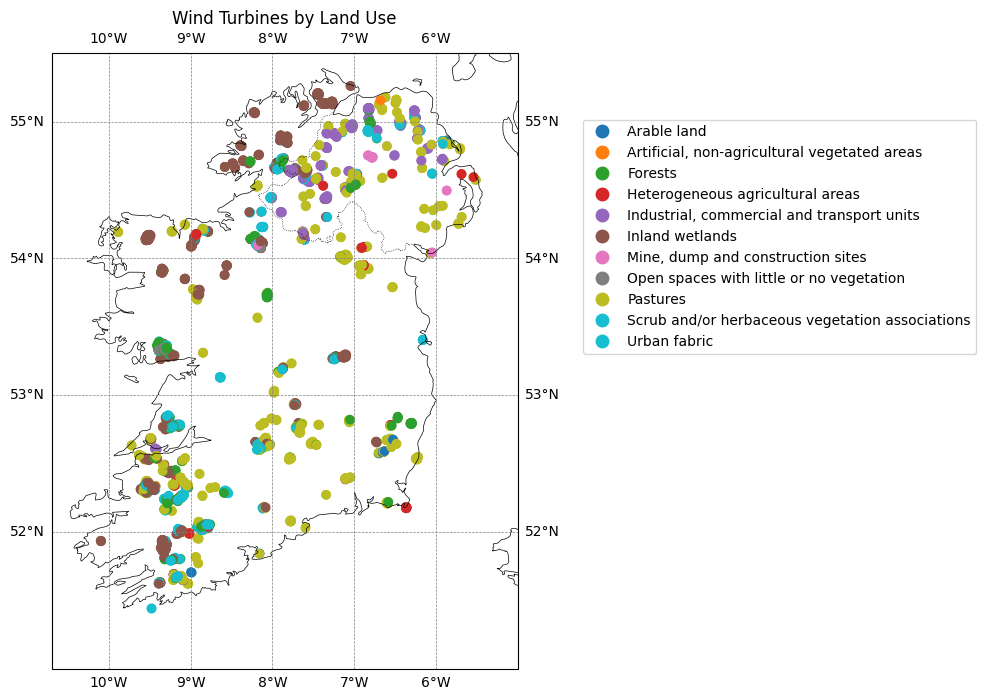

In [34]:
fig, ax = plt.subplots(figsize=(10, 8), subplot_kw={'projection': ccrs.PlateCarree()})
ax.set_extent([-10.7, -5, 51, 55.5])
ax.add_feature(cfeature.COASTLINE, edgecolor='black', linewidth=0.5)
ax.add_feature(cfeature.BORDERS, linestyle=':', edgecolor='black', linewidth=0.5)
ax.gridlines(draw_labels=True, linewidth=0.5, color='gray', linestyle='--')

wind_farms_with_landuse.plot(column='LABEL2', categorical=True, legend=True, ax=ax, legend_kwds={'loc': 'lower right', 'bbox_to_anchor': (2, 0.5)})

ax.set_title('Wind Turbines by Land Use')

plt.show()

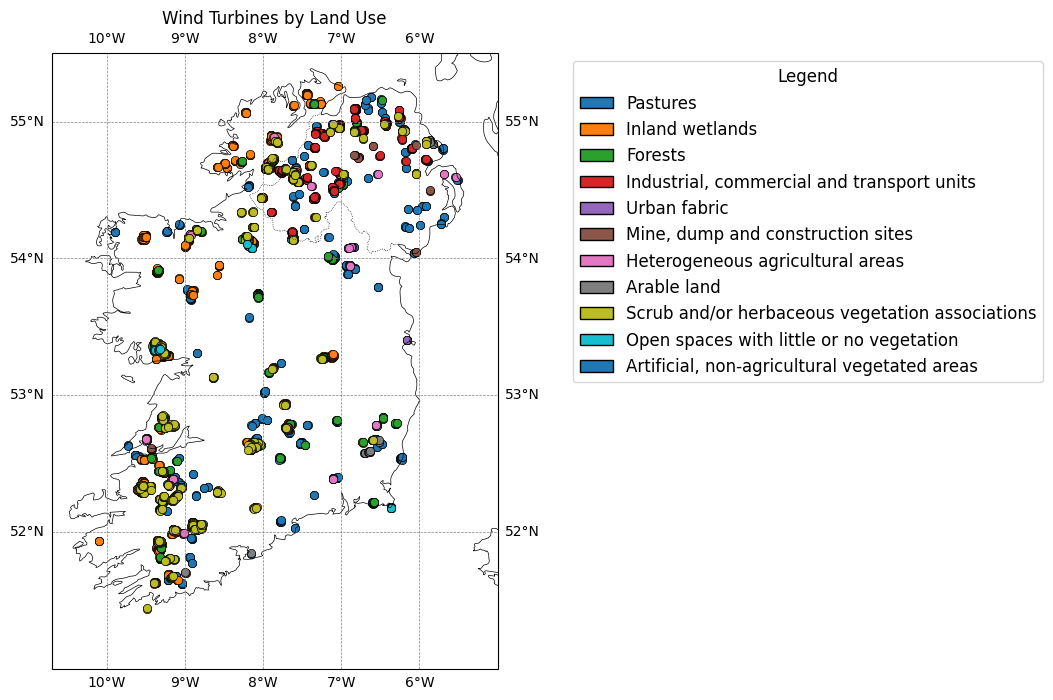

In [35]:
fig, ax = plt.subplots(figsize=(10, 8), subplot_kw={'projection': ccrs.PlateCarree()})
ax.set_extent([-10.7, -5, 51, 55.5])
ax.add_feature(cfeature.COASTLINE, edgecolor='black', linewidth=0.5)
ax.add_feature(cfeature.BORDERS, linestyle=':', edgecolor='black', linewidth=0.5)
ax.gridlines(draw_labels=True, linewidth=0.5, color='gray', linestyle='--')

# wind_farms_with_landuse.plot(column='LABEL2', categorical=True, legend=True, ax=ax, legend_kwds={'loc': 'lower right', 'bbox_to_anchor': (2., 0.5)})

landtypes = wind_farms_with_landuse['LABEL2'].unique()
colors = sns.color_palette('tab10', n_colors=len(landtypes))
color_map = dict(zip(landtypes, colors))

for label, color in color_map.items():
    wind_farms_with_landuse[wind_farms_with_landuse['LABEL2'] == label].plot(ax=ax, facecolor=color, edgecolor='black', lw=0.5)
 
legend_elements = [Patch(facecolor=color_map[label], edgecolor='black', label=label) for label in landtypes]
ax.legend(handles=legend_elements, title='Legend', title_fontsize='large', fontsize='large', bbox_to_anchor=(1.15, 1), loc='upper left')

ax.set_title('Wind Turbines by Land Use')

plt.show()

In [36]:
# absolute number of turbines for each landtype
wind_farms_with_landuse['LABEL2'].value_counts()

LABEL2
Inland wetlands                                    932
Pastures                                           633
Scrub and/or herbaceous vegetation associations    463
Industrial, commercial and transport units         431
Forests                                            319
Heterogeneous agricultural areas                    67
Arable land                                         22
Open spaces with little or no vegetation            20
Mine, dump and construction sites                   19
Urban fabric                                         5
Artificial, non-agricultural vegetated areas         2
Name: count, dtype: int64

In [37]:
# percentage of turbines for each landtype
wind_farms_with_landuse['LABEL2'].value_counts() *100 / wind_farms_with_landuse['LABEL2'].value_counts().sum()

LABEL2
Inland wetlands                                    31.994507
Pastures                                           21.730175
Scrub and/or herbaceous vegetation associations    15.894267
Industrial, commercial and transport units         14.795743
Forests                                            10.950910
Heterogeneous agricultural areas                    2.300034
Arable land                                         0.755235
Open spaces with little or no vegetation            0.686577
Mine, dump and construction sites                   0.652249
Urban fabric                                        0.171644
Artificial, non-agricultural vegetated areas        0.068658
Name: count, dtype: float64

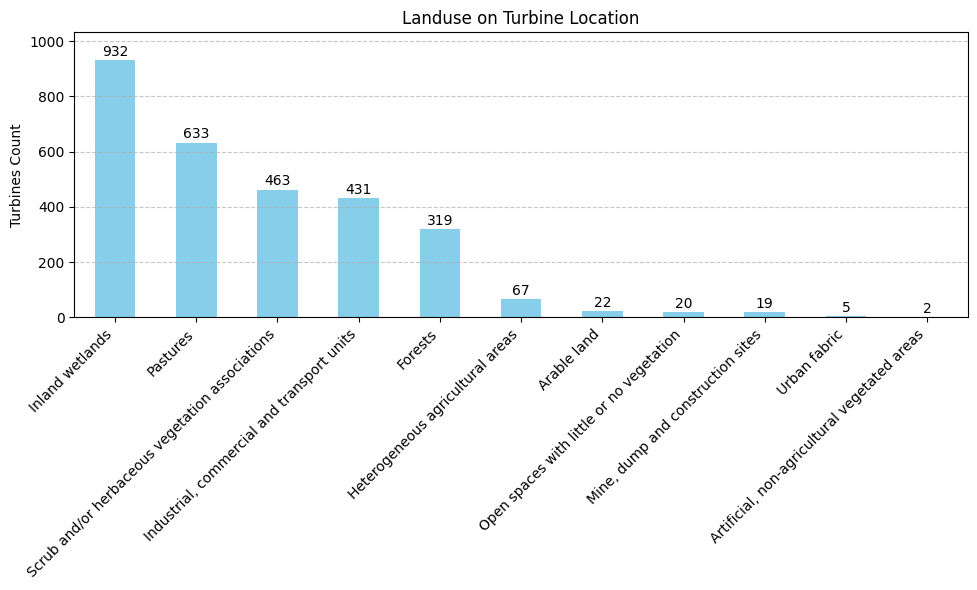

In [38]:
# turbine counts by landuse
landuse_counts = wind_farms_with_landuse['LABEL2'].value_counts()

### plot
plt.figure(figsize=(10, 6))
bars = landuse_counts.plot(kind='bar', color='skyblue')
plt.title('Landuse on Turbine Location') # (Count of Occurrences)
plt.xlabel('')
plt.ylabel('Turbines Count')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)

for bar in bars.patches:
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 5, f'{int(bar.get_height())}', 
             ha='center', va='bottom')

plt.ylim([0, landuse_counts.max()+100])
plt.tight_layout()
plt.show()

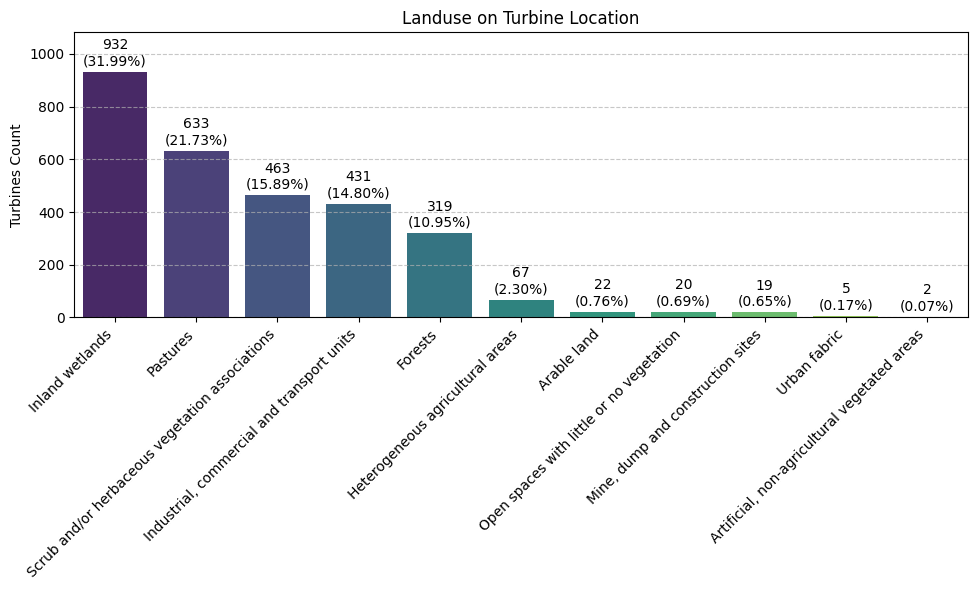

In [39]:
### barchart with percentages
plt.figure(figsize=(10, 6))
ax = sns.barplot(x=landuse_counts.index, y=landuse_counts.values, hue=landuse_counts.index, palette='viridis')

for p in ax.patches:
    x, y = p.get_x() + p.get_width() / 2, p.get_height() + 25
    label_annotation = f'{int(p.get_height())}\n({p.get_height() / len(wind_farms_with_landuse) * 100:.2f}%)'
    ax.annotate(label_annotation, (x, y), ha='center')

plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.title('Landuse on Turbine Location')
plt.xlabel('')
plt.ylabel('Turbines Count')

plt.ylim([0, landuse_counts.values.max()+150])

plt.tight_layout()
plt.show()

Landuse within buffer:  
- turbines belonging to the same farm have the same *cluster_id*: therefore, build an area for each wind farm, encompassing only turbines belonging to the same cluster_id. 
- apply a buffer around each wind farm (area)
- detect landuses within the buffers

In [40]:
print('Total number of wind farms available: {}'.format(wind_gdf.cluster_id.nunique()))

Total number of wind farms available: 301


Build geometries of wind farms via convex hull

In [41]:
# group turbines into farms
farms_gdf = wind_gdf.groupby('cluster_id')

# create polygons for each wind farm
wind_farms = []
for cluster_id, group in farms_gdf:
    # build a MultiPoint object from turbine locations
    turbine_points_union = MultiPoint(group.geometry.values)
    # create a convex hull around turbine_points_union
    farm_by_convex_hull = turbine_points_union.convex_hull
    wind_farms.append((cluster_id, farm_by_convex_hull))


wind_farms_gdf = gpd.GeoDataFrame(wind_farms, columns=['cluster_id', 'geometry'], crs=epsg_latlon)
wind_farms_gdf_metric = wind_farms_gdf.to_crs(epsg_meter)

In [42]:
wind_farms_gdf_metric.geometry.type.unique() # LineString when only 2 nodes inside

array(['LineString', 'Polygon'], dtype=object)

In [43]:
wind_farms_gdf_metric

cluster_id                                           geometry
0           0.0  LINESTRING (3149987.548 3380933.402, 3150177.6...
1           1.0  POLYGON ((3200730.834 3412587.659, 3200310.892...
2           2.0  POLYGON ((3121523.798 3452167.321, 3121121.726...
3           3.0  POLYGON ((3294932.55 3636859.983, 3294886.01 3...
4           4.0  POLYGON ((3256387.782 3485505.025, 3256406.551...
..          ...                                                ...
296       354.0  LINESTRING (3254729.004 3621619.418, 3255312.8...
297       355.0  LINESTRING (3319917.098 3630593.341, 3319624.1...
298       356.0  LINESTRING (3320113.905 3631522.002, 3320100.6...
299       357.0  POLYGON ((3041501.779 3631446.465, 3041688.815...
300       358.0  LINESTRING (3058517.974 3410286.989, 3058189.9...

[301 rows x 2 columns]

In [44]:
buffer_radius = 1000  # in meters
landuse_around_wind_farm = find_landuses_within_buffer(wind_farms_gdf_metric, landuse_gdf_metric, 'cluster_id', 'LABEL2', buffer_radius) # df format
landuse_around_wind_dict = landuse_around_wind_farm.set_index('cluster_id').to_dict()['LABEL2'] # dict format

In [45]:
for farm_id, landuse in landuse_around_wind_dict.items():
    print(f'Wind Farm n. {farm_id} presents the following landtypes within a {buffer_radius}-meters buffer:', ', '.join(landuse))

Wind Farm n. 0.0 presents the following landtypes within a 1000-meters buffer: Pastures, Forests
Wind Farm n. 1.0 presents the following landtypes within a 1000-meters buffer: Heterogeneous agricultural areas, Scrub and/or herbaceous vegetation associations, Forests, Inland wetlands, Pastures
Wind Farm n. 2.0 presents the following landtypes within a 1000-meters buffer: Pastures, Forests
Wind Farm n. 3.0 presents the following landtypes within a 1000-meters buffer: Pastures, Scrub and/or herbaceous vegetation associations, Forests, Industrial, commercial and transport units
Wind Farm n. 4.0 presents the following landtypes within a 1000-meters buffer: Mine, dump and construction sites, Arable land, Industrial, commercial and transport units, Urban fabric
Wind Farm n. 5.0 presents the following landtypes within a 1000-meters buffer: Pastures, Scrub and/or herbaceous vegetation associations, Forests, Inland wetlands
Wind Farm n. 6.0 presents the following landtypes within a 1000-meters b

In [46]:
all_landuse_in_list = landuse_around_wind_farm.LABEL2.explode().tolist() # join all landuses in a single list (each landuse appearing as many times as found in the dataset)

landuse_around_cnt = Counter(all_landuse_in_list)
landuse_around_cnt

Counter({'Pastures': 264,
         'Scrub and/or herbaceous vegetation associations': 198,
         'Forests': 196,
         'Inland wetlands': 163,
         'Heterogeneous agricultural areas': 124,
         'Industrial, commercial and transport units': 46,
         'Arable land': 32,
         'Mine, dump and construction sites': 19,
         'Urban fabric': 17,
         'Open spaces with little or no vegetation': 13,
         'Marine waters': 12,
         'Inland waters': 12,
         'Artificial, non-agricultural vegetated areas': 8,
         'Maritime wetlands': 7})

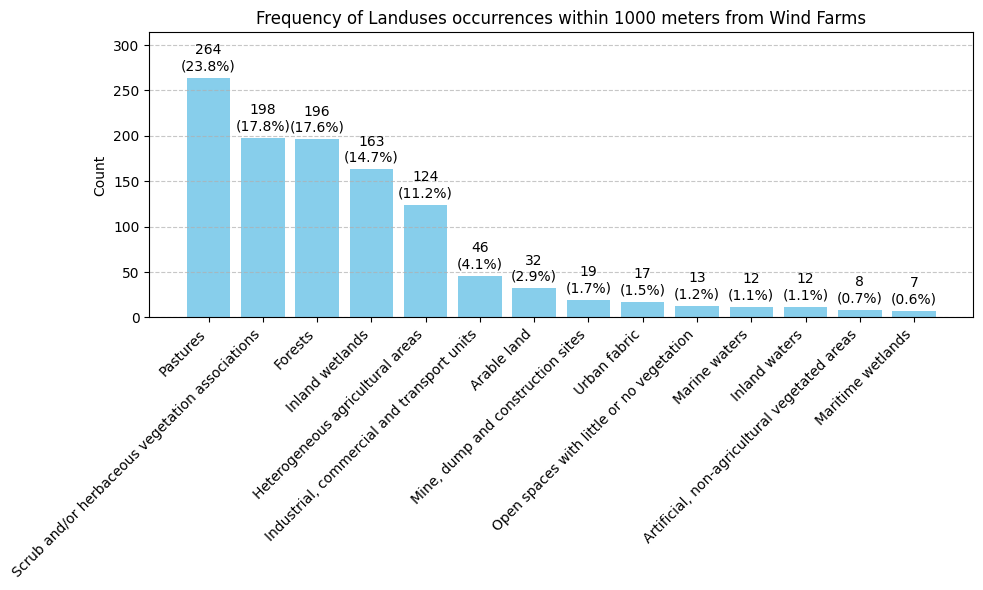

In [47]:
freq_landuse_types(landuse_around_cnt, f'Frequency of Landuses occurrences within {buffer_radius} meters from Wind Farms')

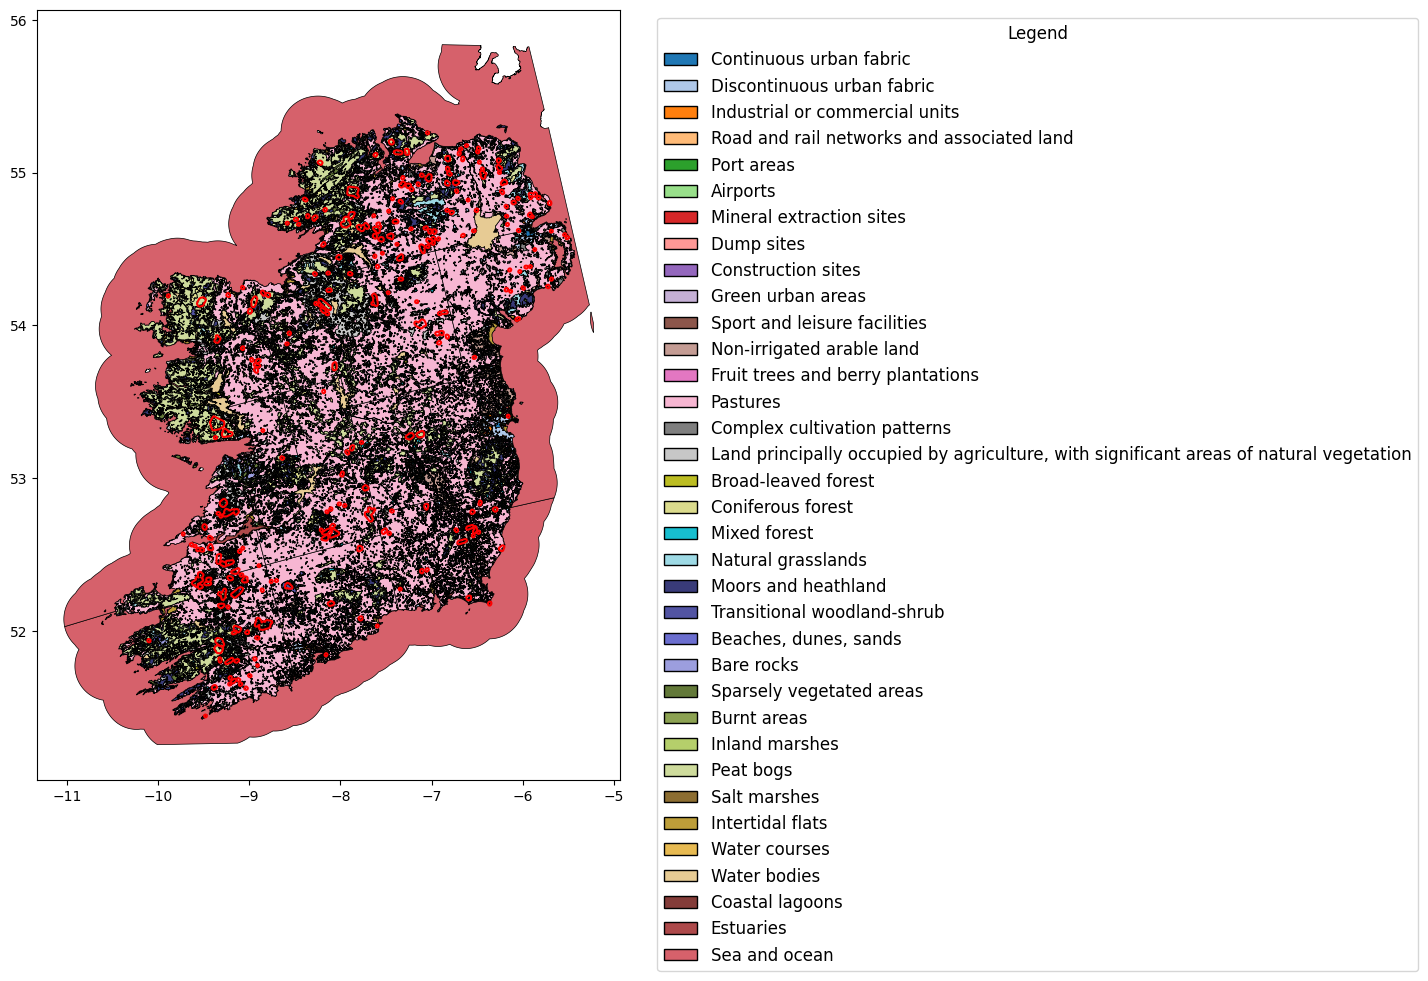

In [ ]:
# plot wind infrastructure buffers over landuse
buffer_for_viz = 1000
wind_farms_gdf_metric_buffered = wind_farms_gdf_metric.copy()
wind_farms_gdf_metric_buffered['geometry'] = wind_farms_gdf_metric_buffered.geometry.buffer(buffer_for_viz)
wind_farms_gdf_buffered = wind_farms_gdf_metric_buffered.to_crs(gdf.crs)
gdf_by_buffer = gpd.overlay(wind_farms_gdf_buffered, gdf, how='intersection')

unioned_polygon_wind = unary_union(wind_farms_gdf_buffered.geometry)
perimeter_wind = unioned_polygon_wind.boundary
perimeter_wind_gdf = gpd.GeoDataFrame(geometry=[perimeter_wind], crs=wind_farms_gdf_buffered.crs)


## plot
# CORINE landuse IE map
lab = 'LABEL3'
# unique labels 
unique_labels = gdf[lab].unique()
num_labels = len(unique_labels)
    
# map label to colors (ensure there are enough unique colors for all unique labels --> max num labels in LABEL3 equal to 35)
colors = plt.cm.tab20.colors + plt.cm.tab20b.colors + plt.cm.tab20c.colors
cmap = ListedColormap(colors[:num_labels])
color_map = {label: cmap(i) for i, label in enumerate(unique_labels)}

# plot
fig, ax = plt.subplots(figsize=(10, 10))
for label, color in color_map.items():
    gdf[gdf[lab] == label].plot(ax=ax, facecolor=color, edgecolor='black', lw=0.5)

# legend 
legend_elements = [Patch(facecolor=color_map[label], edgecolor='black', label=label) for label in unique_labels]
ax.legend(handles=legend_elements, title='Legend', title_fontsize='large', fontsize='large', bbox_to_anchor=(1.05, 1), loc='upper left')

# plot buffers around wind farms on top of map
perimeter_wind_gdf.plot(ax=ax, color='red')
plt.show()

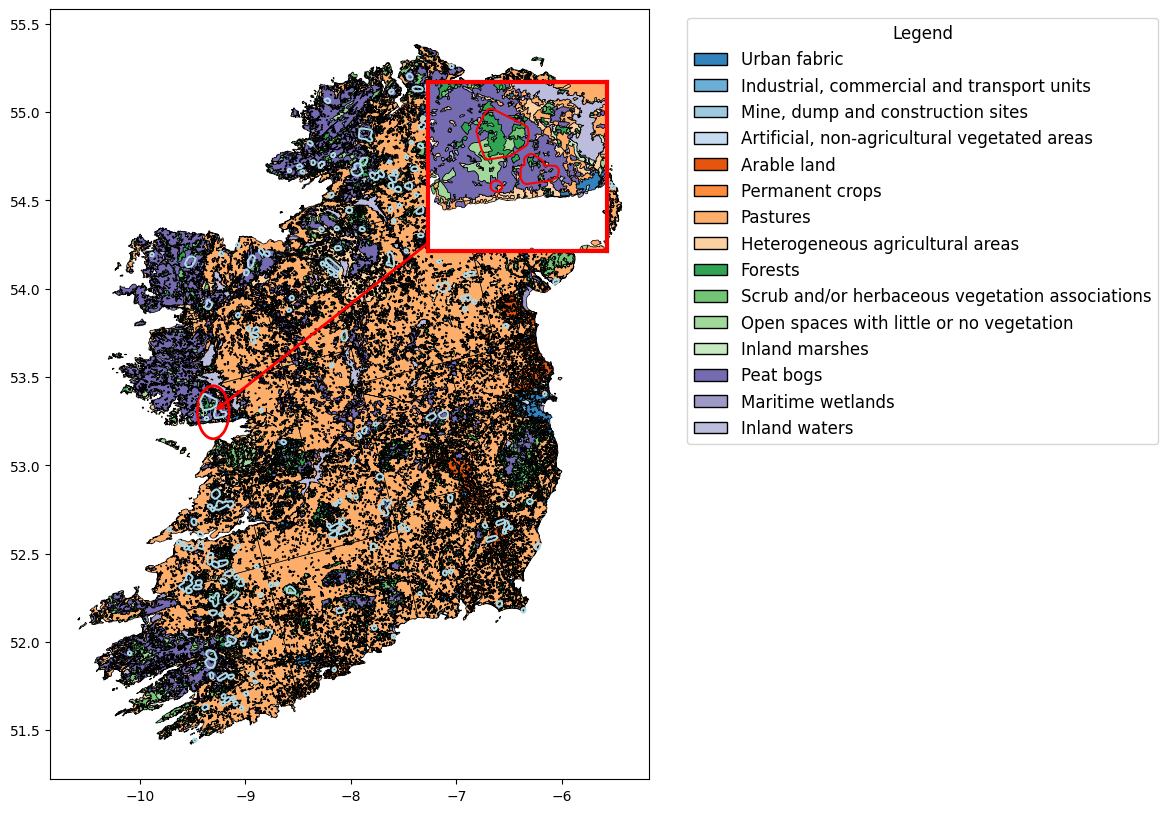

In [ ]:
# PLOT MAPS WITH ZOOM IN SECTION: HERE FOCUS ON A PEAT BOGS AREA WHERE WIND FARMS ARE LOCATED
# look for bbox_min_lon, bbox_min_lat, bbox_max_lon, bbox_max_lat and change their value to zoom in a different area

# CORINE landuse IE map
lab = 'LABEL2'
gdf_peatbogs = gdf.copy()
gdf_peatbogs.loc[gdf_peatbogs['LABEL2'] == 'Inland wetlands', 'LABEL2'] = gdf_peatbogs['LABEL3'] # ADD TO LABEL2 THE DISTINCTION OF DIFFERENT INLAND WETLANDS FROM LABEL3
# unique labels 
unique_labels = gdf_peatbogs[lab].unique().tolist()
unique_labels.remove('Marine waters') # LABEL3 "Sea and ocean"
num_labels = len(unique_labels)
    
# map label to colors (ensure there are enough unique colors for all unique labels --> max num labels in LABEL3 equal to 35)
colors = plt.cm.tab20c.colors # colors = tuple( [tup for tup in colors if tup[0] <= 0.8] ) # remove red from landtype colors
cmap = ListedColormap(colors[:num_labels])
color_map = {label: cmap(i) for i, label in enumerate(unique_labels)}

# plot
fig, ax = plt.subplots(figsize=(10, 10))
for label, color in color_map.items():
    gdf_peatbogs[gdf_peatbogs[lab] == label].plot(ax=ax, facecolor=color, edgecolor='black', lw=0.5)

# legend 
legend_elements = [Patch(facecolor=color_map[label], edgecolor='black', label=label) for label in unique_labels]
ax.legend(handles=legend_elements, title='Legend', title_fontsize='large', fontsize='large', bbox_to_anchor=(1.05, 1), loc='upper left')

# plot all buffers around wind farms on top of map
perimeter_wind_gdf.plot(ax=ax, color='lightblue', edgecolor='blue')


## ZOOM IN SECTION

# bbox area West from Galway, which is interested by peat bogs - defined using bboxfinder.com
bbox_min_lon, bbox_min_lat, bbox_max_lon, bbox_max_lat = -9.574585, 53.148829, -9.036942, 53.451260
# center of the bounding box for placing the circle
center_lon = (bbox_min_lon + bbox_max_lon) / 2
center_lat = (bbox_min_lat + bbox_max_lat) / 2

# add circle on map highlighting peatlands area that you want to zoom-in
circle = Circle((center_lon, center_lat), radius=0.15, edgecolor='red', facecolor='none', linewidth=2)
ax.add_patch(circle)

# zoomed-in area (to be plotted inside the inserted ax)
inset_ax = inset_axes(ax, width='30%', height='30%', loc='upper right', borderpad=3)
# zoom-in box border
for spine in inset_ax.spines.values():
    spine.set_edgecolor('red')
    spine.set_linewidth(3)


# CORINE LAND TYPES PLOT ON ZOOM-IN
for label, color in color_map.items():
    gdf_peatbogs[gdf_peatbogs[lab] == label].plot(ax=inset_ax, facecolor=color, edgecolor='black', lw=0.5)
# BUFFERS PERIMETER PLOT ON ZOOM-IN
perimeter_wind_gdf.plot(ax=inset_ax, color='red') 


# arrow
ax.annotate(
    '',  
    xy = (center_lon, center_lat),  # arrow point location (torwards circle on the main map)
    xytext = (0.8, 0.8),  # start of arrow, near zoomed-in area
    textcoords = 'axes fraction',
    arrowprops = dict(color = 'red', arrowstyle = '->', linewidth = 2)
)


# set the extent of the inset map to focus on the bounding box area
inset_ax.set_xlim(bbox_min_lon, bbox_max_lon)
inset_ax.set_ylim(bbox_min_lat, bbox_max_lat)

inset_ax.set_xticklabels([])
inset_ax.set_yticklabels([])
inset_ax.set_xticks([])
inset_ax.set_yticks([])

inset_ax.axis('on')

# plt.savefig('img/peat_bogs_zoom_IE.png', dpi=300, bbox_inches='tight')

plt.show()

In [50]:
# compute num landuses around each farm (length of each set)
landuse_around_wind_farm['num_landuses_around'] = landuse_around_wind_farm.LABEL2.apply(lambda x: len(x))

# average number of landtypes within buffer
print('Average num of landtypes around each wind farm: {}'.format(landuse_around_wind_farm['num_landuses_around'].mean()))
# std
print('Standard deviation of num of landtypes: {}'.format(landuse_around_wind_farm['num_landuses_around'].std()))
# max
print('Maximum num of landtypes around each wind farm: {}'.format(landuse_around_wind_farm['num_landuses_around'].max()))
# min
print('Minimum num of landtypes around each wind farm: {}'.format(landuse_around_wind_farm['num_landuses_around'].min()))

Average num of landtypes around each wind farm: 3.691029900332226
Standard deviation of num of landtypes: 1.321950302559186
Maximum num of landtypes around each wind farm: 7
Minimum num of landtypes around each wind farm: 1


In [51]:
# add geometry to landuse_around_wind_df
landuse_around_wind_gdf = pd.merge(wind_farms_gdf, landuse_around_wind_farm, how='right')
landuse_around_wind_gdf

cluster_id                                           geometry  \
0           0.0   LINESTRING (-7.34497 52.2733, -7.34195 52.27295)   
1           1.0  POLYGON ((-6.72467 52.65481, -6.73373 52.66162...   
2           2.0  POLYGON ((-8.00876 52.82988, -8.01504 52.83011...   
3           3.0  POLYGON ((-6.10443 54.80076, -6.10572 54.80211...   
4           4.0  POLYGON ((-6.16006 53.40315, -6.16026 53.40441...   
..          ...                                                ...   
296       354.0  LINESTRING (-6.65933 54.58647, -6.65145 54.58994)   
297       355.0  LINESTRING (-5.70262 54.79519, -5.70841 54.79802)   
298       356.0  LINESTRING (-5.70281 54.80369, -5.70352 54.80498)   
299       357.0  POLYGON ((-9.88794 54.19091, -9.88652 54.19411...   
300       358.0  LINESTRING (-8.75699 52.32542, -8.76012 52.32111)   

                                                LABEL2  num_landuses_around  
0                                  {Pastures, Forests}                    2  
1    {Heterogeneous agricultural areas, Scrub and/o...                    5  
2                                  {Pastures, Forests}                    2  
3    {Pastures, Scrub and/or herbaceous vegetation ...                    4  
4    {Mine, dump and construction sites, Arable lan...                    4  
..                                                 ...                  ...  
296                                         {Pastures}                    1  
297  {Pastures, Scrub and/or herbaceous vegetation ...                    4  
298  {Pastures, Scrub and/or herbaceous vegetation ...                    3  
299                        {Pastures, Inland wetlands}                    2  
300                                {Pastures, Forests}                    2  

[301 rows x 4 columns]

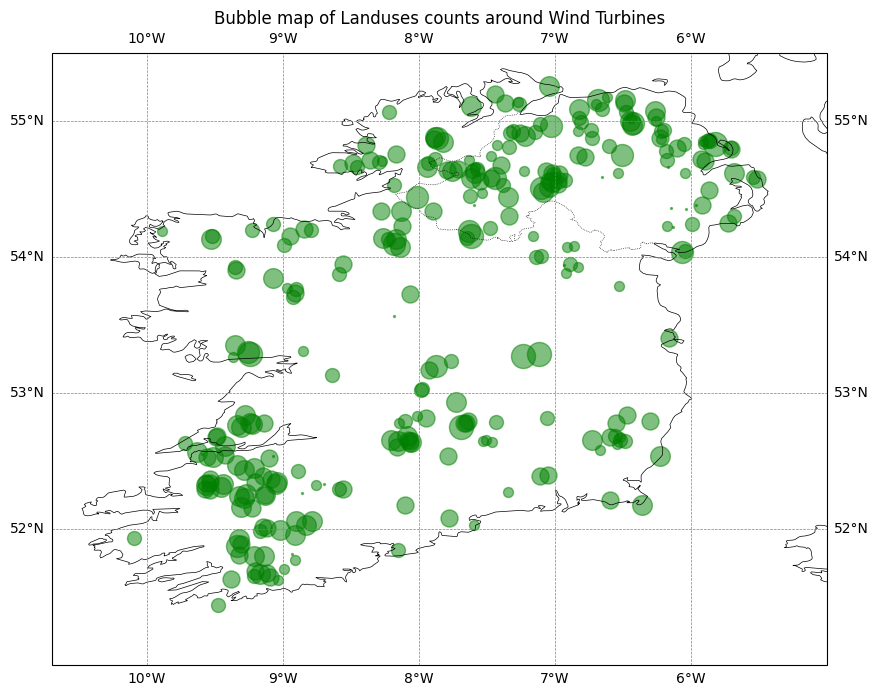

In [52]:
### BUBBLE MAP
# the bigger the bubbles, the more diverse landtypes are present around wind farms (within buffer_radius meters)
bubble_map(gdf_mercator = landuse_around_wind_gdf, 
           bubble_sizes_column = 'num_landuses_around',
           zoom_area = [-10.7, -5, 51, 55.5], 
           title = 'Bubble map of Landuses counts around Wind Turbines')

#### Area occupied by each landuse - wind farms

Compute the percentage of land within the buffer occupied by each landuse available.

In [53]:
landuse_around_wind_meter = landuse_around_wind_gdf.to_crs(epsg_meter)
share_laduse_around_wind = find_area_covered_by_landuse_within_buffer(landuse_around_infra_gdf1_metric = landuse_around_wind_meter[['cluster_id', 'geometry']].copy(),
                                                                                landuse_gdf2_metric = landuse_gdf_metric, 
                                                                                unique_id_gdf1 = 'cluster_id', 
                                                                                label_column_gdf2 = 'LABEL2', 
                                                                                buffer_radius = buffer_radius)

In [54]:
share_laduse_around_wind

cluster_id                                           LABEL2  \
0           0.0                                         Pastures   
1           1.0                                          Forests   
2           1.0                                  Inland wetlands   
3           1.0  Scrub and/or herbaceous vegetation associations   
4           2.0                                         Pastures   
..          ...                                              ...   
595       354.0                                         Pastures   
596       355.0                                         Pastures   
597       356.0                                         Pastures   
598       357.0                                         Pastures   
599       358.0                                         Pastures   

     area_intersection  landuse_share_by_id  
0         1.706324e+06           100.000000  
1         1.420006e+06            55.623090  
2         7.216897e+05            28.269314  
3         4.112121e+05            16.107595  
4         3.992014e+06           100.000000  
..                 ...                  ...  
595       4.414688e+06           100.000000  
596       3.440140e+06           100.000000  
597       3.092307e+06           100.000000  
598       1.886910e+06           100.000000  
599       3.440003e+06           100.000000  

[600 rows x 4 columns]

In [55]:
# TOTAL AREA OCCUPIED BY ALL LANDTYPE CATEGORIES IN THE SURROUNDINGS OF ALL FARMS IN THE COUNTRY
grp_wind_land = share_laduse_around_wind.groupby(['LABEL2']).aggregate({'area_intersection':'sum'}).reset_index()
grp_wind_land

LABEL2  area_intersection
0                                       Arable land       1.930568e+07
1      Artificial, non-agricultural vegetated areas       2.733968e+05
2                                           Forests       2.402738e+08
3                  Heterogeneous agricultural areas       5.058751e+07
4        Industrial, commercial and transport units       2.896678e+07
5                                     Inland waters       8.305106e+05
6                                   Inland wetlands       5.685109e+08
7                                     Marine waters       3.181443e+06
8                 Mine, dump and construction sites       4.556770e+06
9          Open spaces with little or no vegetation       1.317019e+07
10                                         Pastures       7.474031e+08
11  Scrub and/or herbaceous vegetation associations       3.167091e+08
12                                     Urban fabric       1.799493e+06

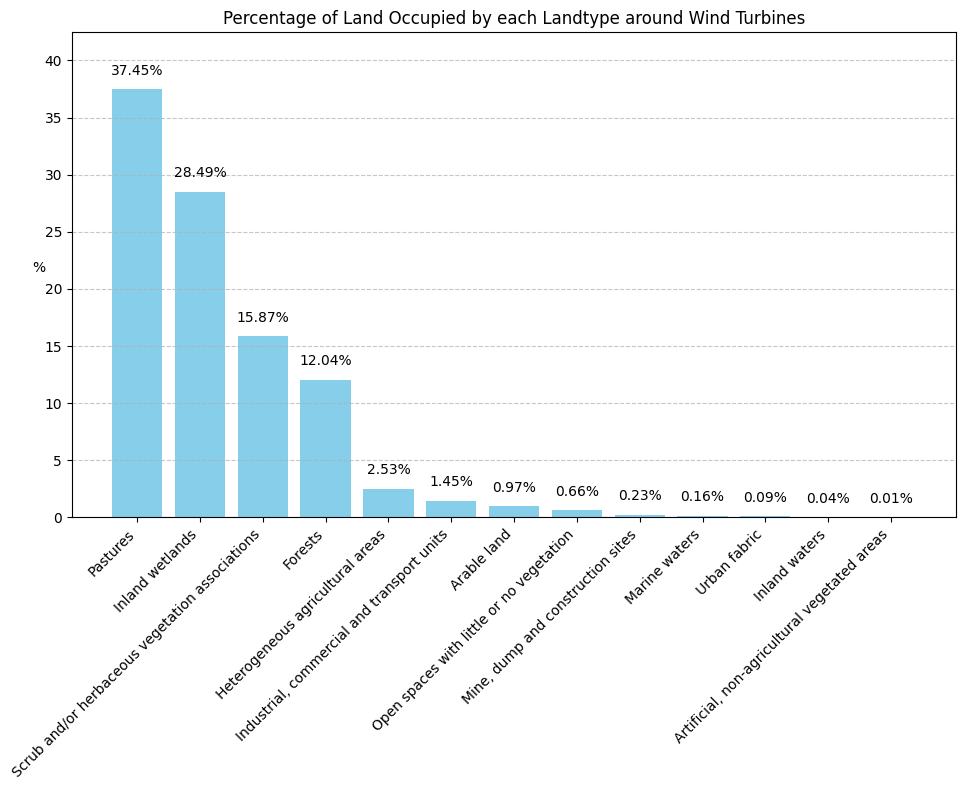

In [56]:
total_area = grp_wind_land['area_intersection'].sum()
grp_wind_land['perc_landuse'] = (grp_wind_land['area_intersection'] / total_area) * 100

# sort bars
grp_wind_land_sorted = grp_wind_land.sort_values(by='perc_landuse', ascending=False)

### plot barchart
plt.figure(figsize=(10, 8))
bars = plt.bar(grp_wind_land_sorted['LABEL2'], grp_wind_land_sorted['perc_landuse'], color='skyblue')
plt.xlabel('')
plt.ylabel('%', rotation=360)  
plt.title('Percentage of Land Occupied by each Landtype around Wind Turbines')

for bar, percentage in zip(bars, grp_wind_land_sorted['perc_landuse']):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 1, f'{percentage:.2f}%', ha='center', va='bottom')

plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.ylim([0, grp_wind_land_sorted['perc_landuse'].max() + 5])
plt.tight_layout()
plt.show()

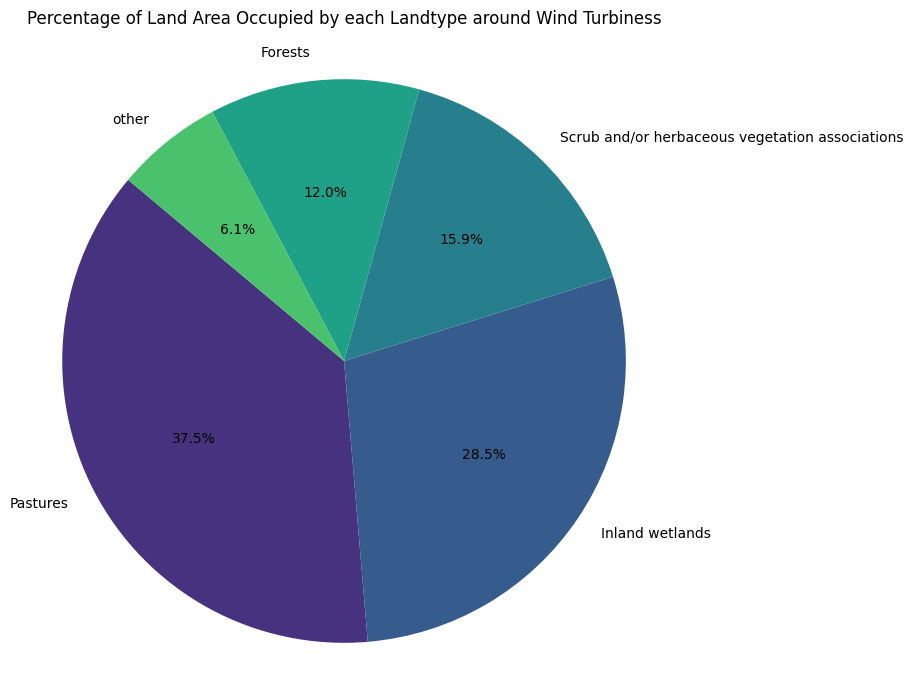

In [57]:
viz_threshold = 4.
grp_wind_land_above_threshold = grp_wind_land_sorted[grp_wind_land_sorted.perc_landuse > viz_threshold].reset_index(drop=True)
others_row = pd.DataFrame([['other', grp_wind_land_sorted[grp_wind_land_sorted.perc_landuse < viz_threshold].area_intersection.sum(), grp_wind_land_sorted[grp_wind_land_sorted.perc_landuse < viz_threshold].perc_landuse.sum()]], columns=grp_wind_land_above_threshold.columns)
reduced_wind_landuse = pd.concat([grp_wind_land_above_threshold, others_row], ignore_index=True)

### plot pie chart
plt.figure(figsize=(8, 8))
plt.pie(reduced_wind_landuse.perc_landuse, labels=reduced_wind_landuse['LABEL2'], autopct='%1.1f%%', startangle=140, colors=sns.color_palette('viridis') ) # rotatelabels=True
plt.title('Percentage of Land Area Occupied by each Landtype around Wind Turbiness\n') # Percentage of Total Area
plt.axis('equal')  
plt.show()

#### SOLAR

Analyse the landtypes within a certain buffer.

In [58]:
solar_df = pd.read_csv(solar_data_path, index_col=0)
solar_df['geometry'] = solar_df['geometry'].apply(wkt.loads)

solar_gdf = gpd.GeoDataFrame(solar_df, crs=epsg_latlon, geometry='geometry')
solar_gdf_metric = solar_gdf.to_crs(epsg_meter)

In [59]:
landuse_around_solar_df = find_landuses_within_buffer(solar_gdf_metric, landuse_gdf_metric, 'id', 'LABEL2', buffer_radius) # df format
landuse_around_solar_dict = landuse_around_solar_df.set_index('id').to_dict()['LABEL2'] # dict format

In [60]:
landuse_around_solar_df

id                                             LABEL2
0   a1059582850  {Pastures, Arable land, Industrial, commercial...
1   a1232677304                                         {Pastures}
2   a1243151394  {Heterogeneous agricultural areas, Mine, dump ...
3   a1363381902  {Pastures, Scrub and/or herbaceous vegetation ...
4   a1363385996  {Arable land, Heterogeneous agricultural areas...
5   a1363390256                                         {Pastures}
6   a1363395084  {Pastures, Industrial, commercial and transpor...
7   a1363413750  {Pastures, Arable land, Industrial, commercial...
8   a1428023156  {Arable land, Mine, dump and construction site...
9   a1437832680  {Artificial, non-agricultural vegetated areas,...
10  a1437838760               {Pastures, Inland wetlands, Forests}
11  a1451395326                                         {Pastures}
12  a1451395328                                         {Pastures}
13  a1492025354                           {Pastures, Urban fabric}
14  a1601430292                           {Pastures, Urban fabric}
15  a1601524644  {Artificial, non-agricultural vegetated areas,...
16  a1752911506  {Pastures, Arable land, Heterogeneous agricult...
17  a1753020812                                         {Pastures}
18  a1801625258                            {Pastures, Arable land}
19  a1877228774                            {Pastures, Arable land}
20  a1877232810  {Arable land, Industrial, commercial and trans...
21  a1877239676                            {Pastures, Arable land}
22    a18918899  {Artificial, non-agricultural vegetated areas,...
23  a1950163808  {Pastures, Arable land, Industrial, commercial...
24    a19938257              {Pastures, Arable land, Urban fabric}
25  a2111924882  {Arable land, Industrial, commercial and trans...
26  a2194478930         {Pastures, Inland wetlands, Inland waters}
27  a2250608196              {Pastures, Arable land, Urban fabric}
28  a2252849510  {Pastures, Artificial, non-agricultural vegeta...
29  a2252854388  {Pastures, Arable land, Heterogeneous agricult...
30  a2252859382  {Pastures, Arable land, Heterogeneous agricult...
31  a2255752246  {Artificial, non-agricultural vegetated areas,...
32  a2256053062  {Pastures, Arable land, Heterogeneous agricult...
33  a2332231872              {Pastures, Arable land, Urban fabric}
34  a2336992388                           {Pastures, Urban fabric}
35  a2346185650  {Artificial, non-agricultural vegetated areas,...
36  a2346185652  {Artificial, non-agricultural vegetated areas,...
37  a2392169994                 {Pastures, Inland waters, Forests}
38  a2409527488                           {Pastures, Urban fabric}
39    a30169775  {Pastures, Arable land, Heterogeneous agricult...
40    a30524107  {Pastures, Scrub and/or herbaceous vegetation ...
41   a970054502          {Pastures, Inland wetlands, Urban fabric}

In [61]:
print('Number of solar farms without associated landuse in the surrounding {} meters (missing CORINE data): {} over {}'.format(buffer_radius, len(landuse_around_solar_df[landuse_around_solar_df.LABEL2.isna()]), len(landuse_around_solar_df)))

Number of solar farms without associated landuse in the surrounding 1000 meters (missing CORINE data): 0 over 42


In [62]:
all_solar_landuses = landuse_around_solar_df.LABEL2.explode().tolist() 
solar_landuse_around_cnt = Counter(all_solar_landuses)
solar_landuse_around_cnt

Counter({'Pastures': 42,
         'Arable land': 22,
         'Urban fabric': 17,
         'Heterogeneous agricultural areas': 13,
         'Industrial, commercial and transport units': 12,
         'Artificial, non-agricultural vegetated areas': 7,
         'Forests': 6,
         'Mine, dump and construction sites': 4,
         'Scrub and/or herbaceous vegetation associations': 4,
         'Inland wetlands': 4,
         'Inland waters': 2,
         'Maritime wetlands': 2,
         'Marine waters': 2})

In [63]:
# compute num landuses around each infrastructure (length of each set)
landuse_around_solar_df['num_landuses_around'] = landuse_around_solar_df.LABEL2.apply(lambda x: len(x))

# average number of landtypes within buffer
print('Average num of landtypes around each solar farm: {}'.format(landuse_around_solar_df['num_landuses_around'].mean()))
# std
print('Standard deviation of num of landtypes: {}'.format(landuse_around_solar_df['num_landuses_around'].std()))
# max
print('Maximum num of landtypes around each solar farm: {}'.format(landuse_around_solar_df['num_landuses_around'].max()))
# min
print('Minimum num of landtypes around each solar farm: {}'.format(landuse_around_solar_df['num_landuses_around'].min()))

Average num of landtypes around each solar farm: 3.261904761904762
Standard deviation of num of landtypes: 1.3978995359680533
Maximum num of landtypes around each solar farm: 6
Minimum num of landtypes around each solar farm: 1


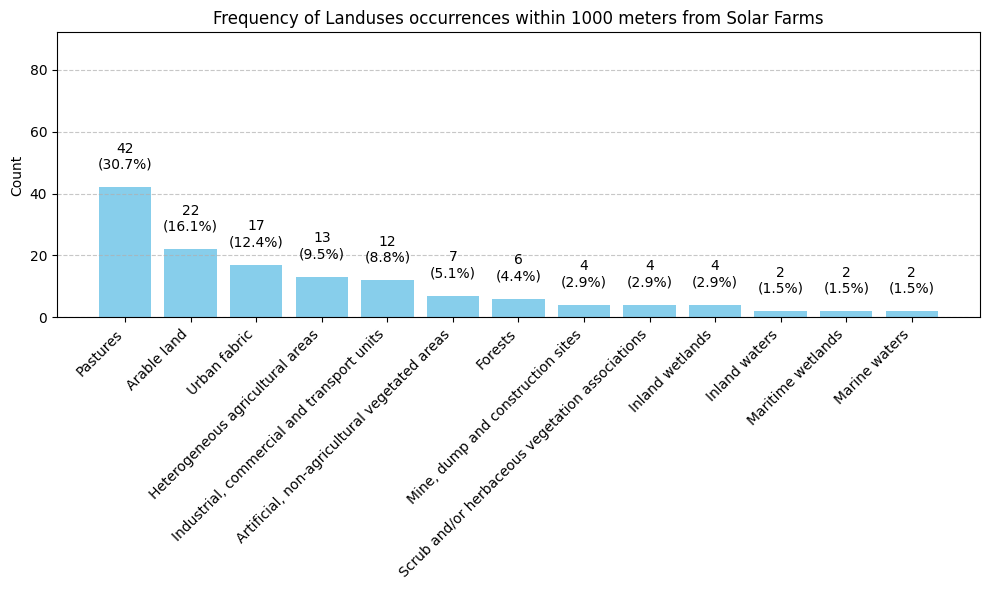

In [64]:
freq_landuse_types(solar_landuse_around_cnt, title_plot=f'Frequency of Landuses occurrences within {buffer_radius} meters from Solar Farms')

In [65]:
# add geometry to landuse_around_solar_df
landuse_around_solar_df = pd.merge(solar_gdf[['id', 'geometry']], landuse_around_solar_df, how='right')
landuse_around_solar_df_mercator = landuse_around_solar_df.to_crs(epsg_latlon)

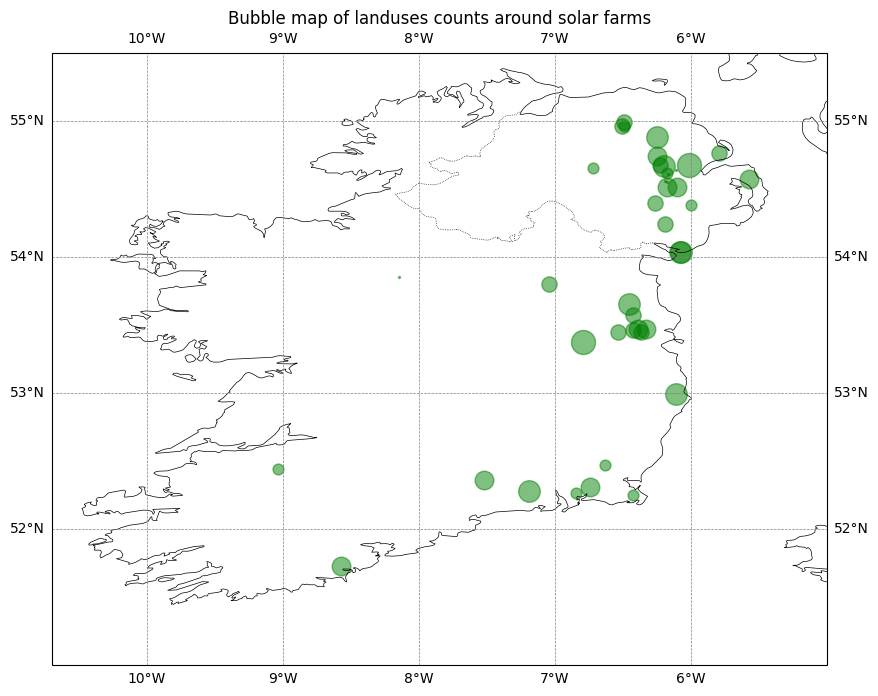

In [66]:
bubble_map(gdf_mercator = landuse_around_solar_df_mercator, 
           zoom_area = [-10.7, -5, 51, 55.5], 
           bubble_sizes_column = 'num_landuses_around',
           title='Bubble map of landuses counts around solar farms')

#### Area occupied by each landuse - solar farms

In [67]:
landuse_around_solar_df_metric = landuse_around_solar_df_mercator.to_crs(epsg_meter)
share_laduse_around_solar = find_area_covered_by_landuse_within_buffer(landuse_around_infra_gdf1_metric = landuse_around_solar_df_metric[['id', 'geometry']].copy(),
                                                                        landuse_gdf2_metric = landuse_gdf_metric, 
                                                                        unique_id_gdf1 = 'id', 
                                                                        label_column_gdf2 = 'LABEL2', 
                                                                        buffer_radius = buffer_radius)

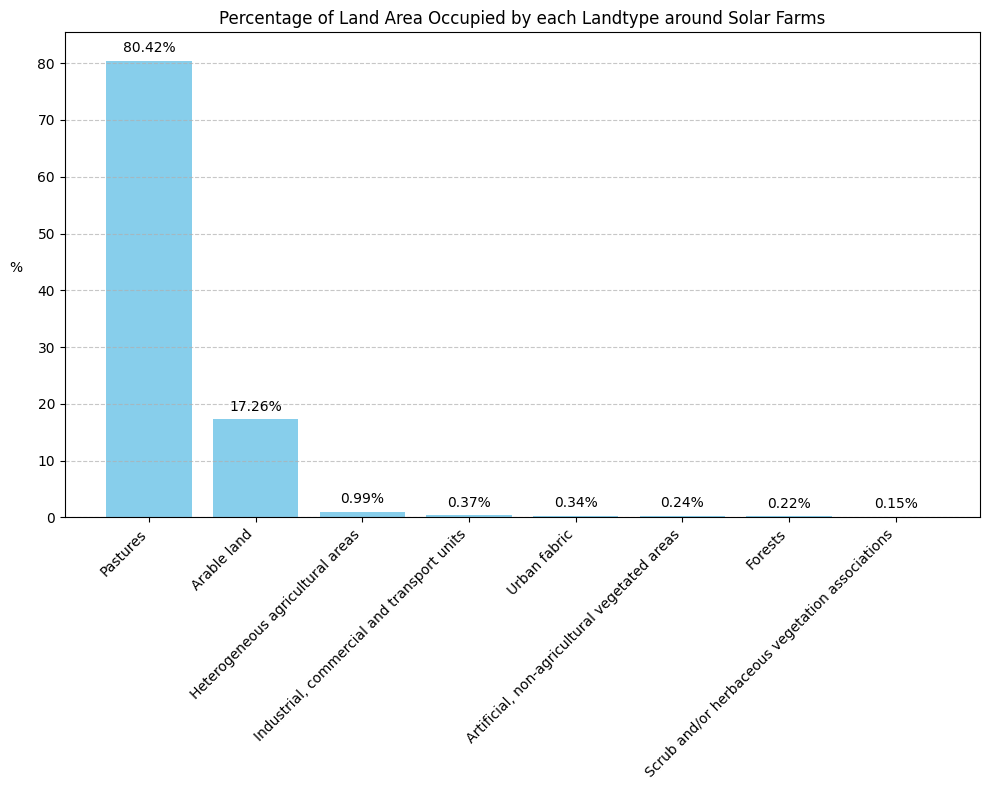

In [68]:
grp_solar_land = share_laduse_around_solar.groupby(['LABEL2']).aggregate({'area_intersection':'sum'}).reset_index()

total_area = grp_solar_land['area_intersection'].sum()
grp_solar_land['perc_landuse'] = (grp_solar_land['area_intersection'] / total_area) * 100

# sort bars
grp_solar_land_sorted = grp_solar_land.sort_values(by='perc_landuse', ascending=False)

### plot barchart
plt.figure(figsize=(10, 8))
bars = plt.bar(grp_solar_land_sorted['LABEL2'], grp_solar_land_sorted['perc_landuse'], color='skyblue')
plt.xlabel('')
plt.ylabel('%       ', rotation=360)  
plt.title('Percentage of Land Area Occupied by each Landtype around Solar Farms')

for bar, percentage in zip(bars, grp_solar_land_sorted['perc_landuse']):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 1, f'{percentage:.2f}%', ha='center', va='bottom')

plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.ylim([0, grp_solar_land_sorted['perc_landuse'].max() + 5])
plt.tight_layout()
plt.show()

In [69]:
grp_solar_land_sorted

LABEL2  area_intersection  \
5                                         Pastures       1.565961e+08   
0                                      Arable land       3.360548e+07   
3                 Heterogeneous agricultural areas       1.935547e+06   
4       Industrial, commercial and transport units       7.207886e+05   
7                                     Urban fabric       6.561139e+05   
1     Artificial, non-agricultural vegetated areas       4.720153e+05   
2                                          Forests       4.330019e+05   
6  Scrub and/or herbaceous vegetation associations       2.974964e+05   

   perc_landuse  
5     80.422599  
0     17.258665  
3      0.994033  
4      0.370173  
7      0.336958  
1      0.242411  
2      0.222375  
6      0.152784

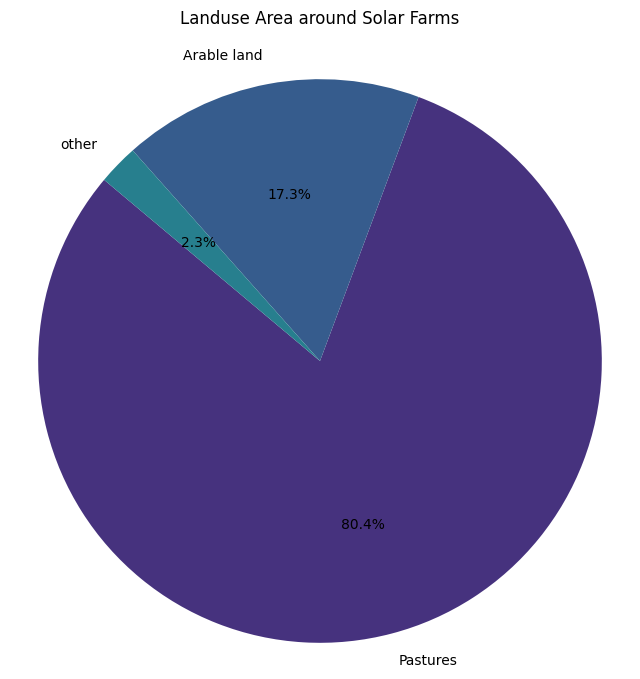

In [70]:
# viz_threshold = 4.
grp_solar_land_above_threshold = grp_solar_land_sorted[grp_solar_land_sorted.perc_landuse > viz_threshold].reset_index(drop=True)
others_row_solar = pd.DataFrame([['other', grp_solar_land_sorted[grp_solar_land_sorted.perc_landuse < viz_threshold].area_intersection.sum(), grp_solar_land_sorted[grp_solar_land_sorted.perc_landuse < viz_threshold].perc_landuse.sum()]], columns=grp_solar_land_above_threshold.columns)
reduced_solar_landuse = pd.concat([grp_solar_land_above_threshold, others_row_solar], ignore_index=True)

### plot pie chart
plt.figure(figsize=(8, 8))
plt.pie(reduced_solar_landuse.perc_landuse, labels=reduced_solar_landuse['LABEL2'], autopct='%1.1f%%', startangle=140, colors=sns.color_palette('viridis')) 
plt.title('Landuse Area around Solar Farms\n') # % of area
plt.axis('equal')  
plt.show()